In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('PJMW_hourly.csv')

In [3]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H')
df.dtypes

Datetime    datetime64[ns]
PJMW_MW            float64
dtype: object

In [4]:
df = df.sort_values(by=['Datetime']).reset_index()
df = df.drop(columns=('index'))

In [5]:
df = df.set_index('Datetime')
df.head()

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0


<AxesSubplot:ylabel='Frequency'>

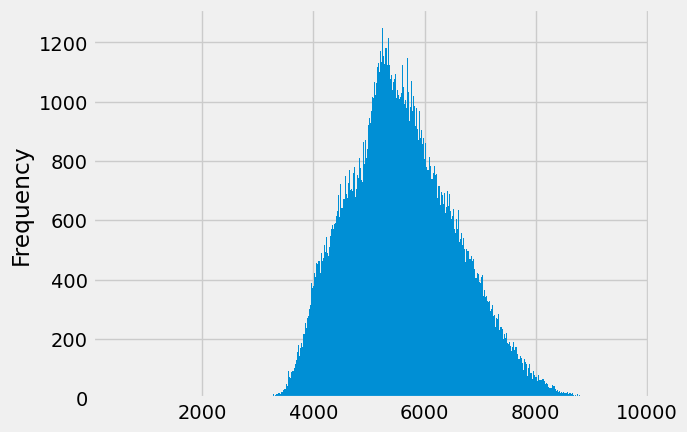

In [6]:
df['PJMW_MW'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

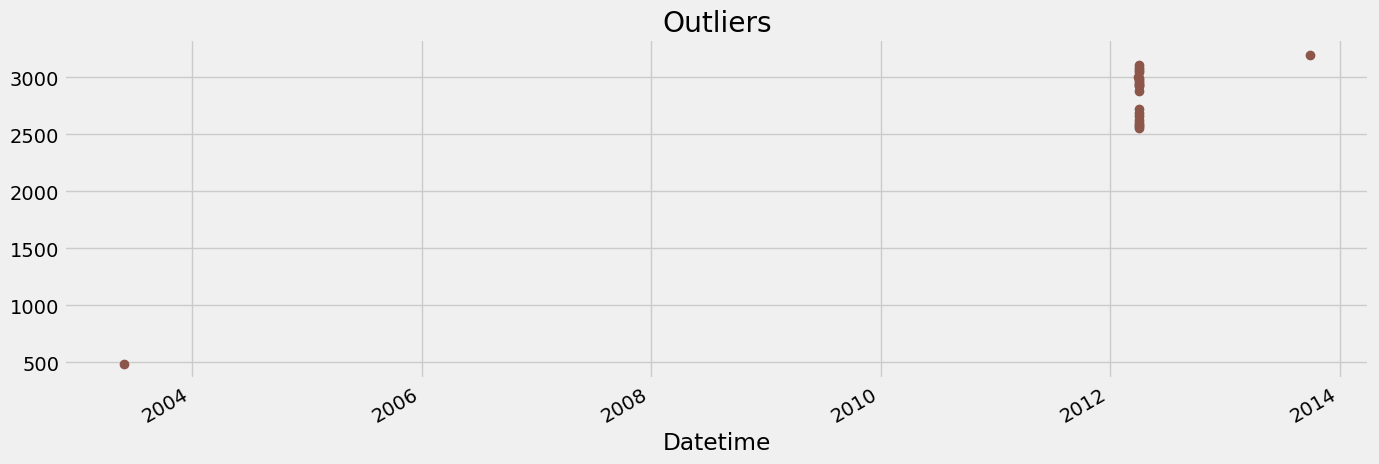

In [7]:
df[df['PJMW_MW'] < 3200]['PJMW_MW'] \
    .plot(style='o',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [8]:
df = df.drop(index = df[df['PJMW_MW'] < 3200].index)

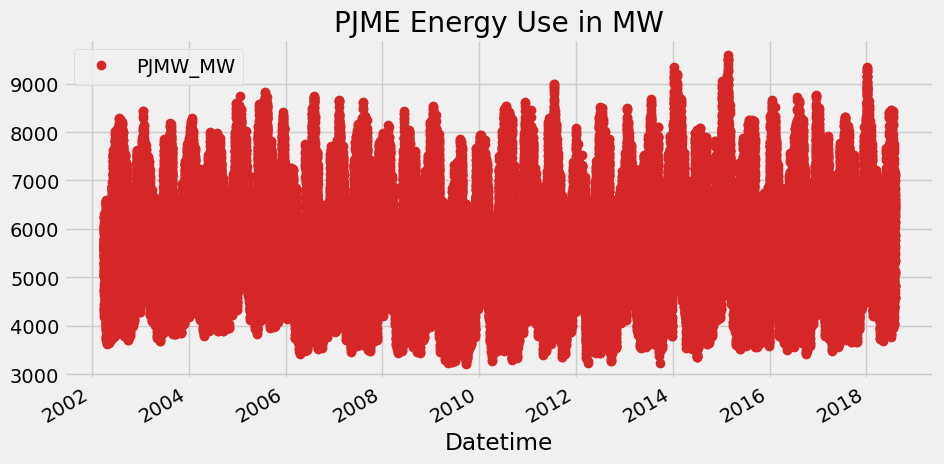

In [9]:
df.plot(style='o',
        figsize=(10, 5),
        color=color_pal[3],
        title='PJME Energy Use in MW')
plt.show()

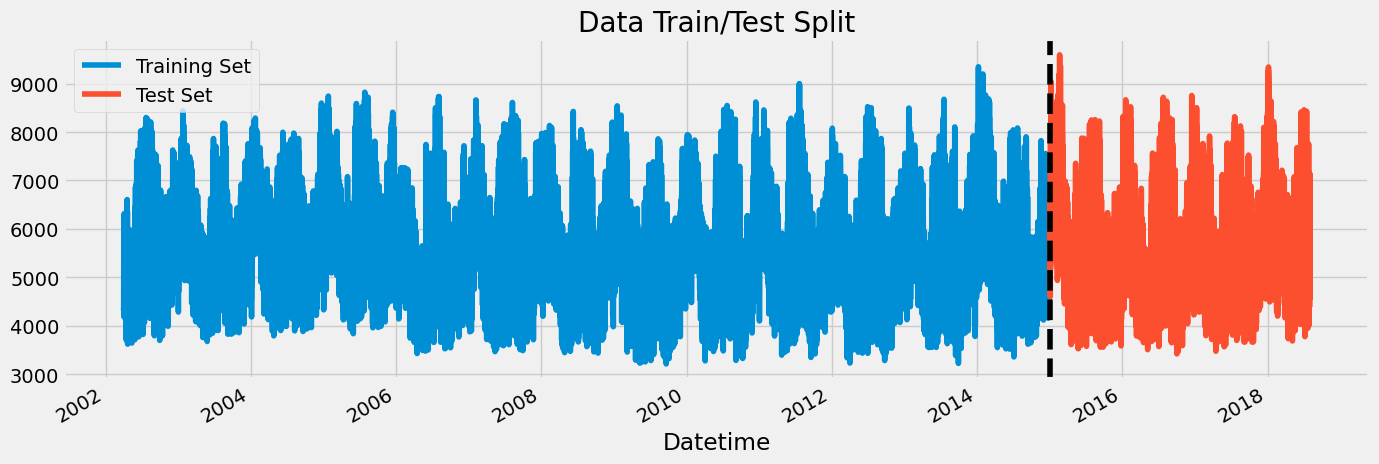

In [10]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

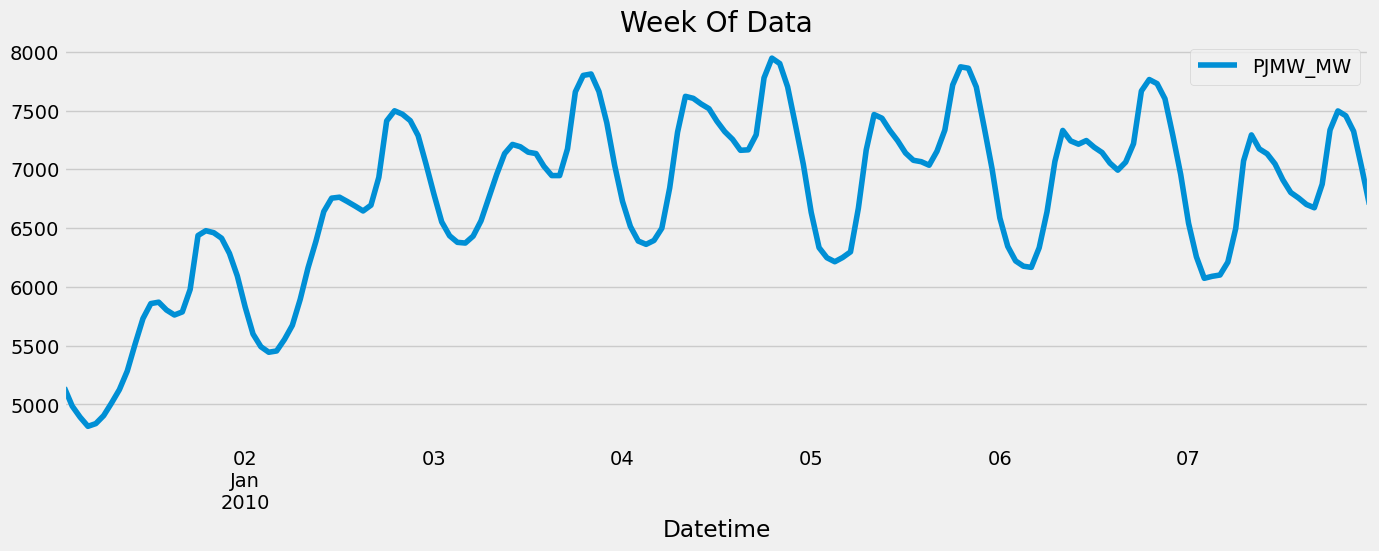

In [11]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [12]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

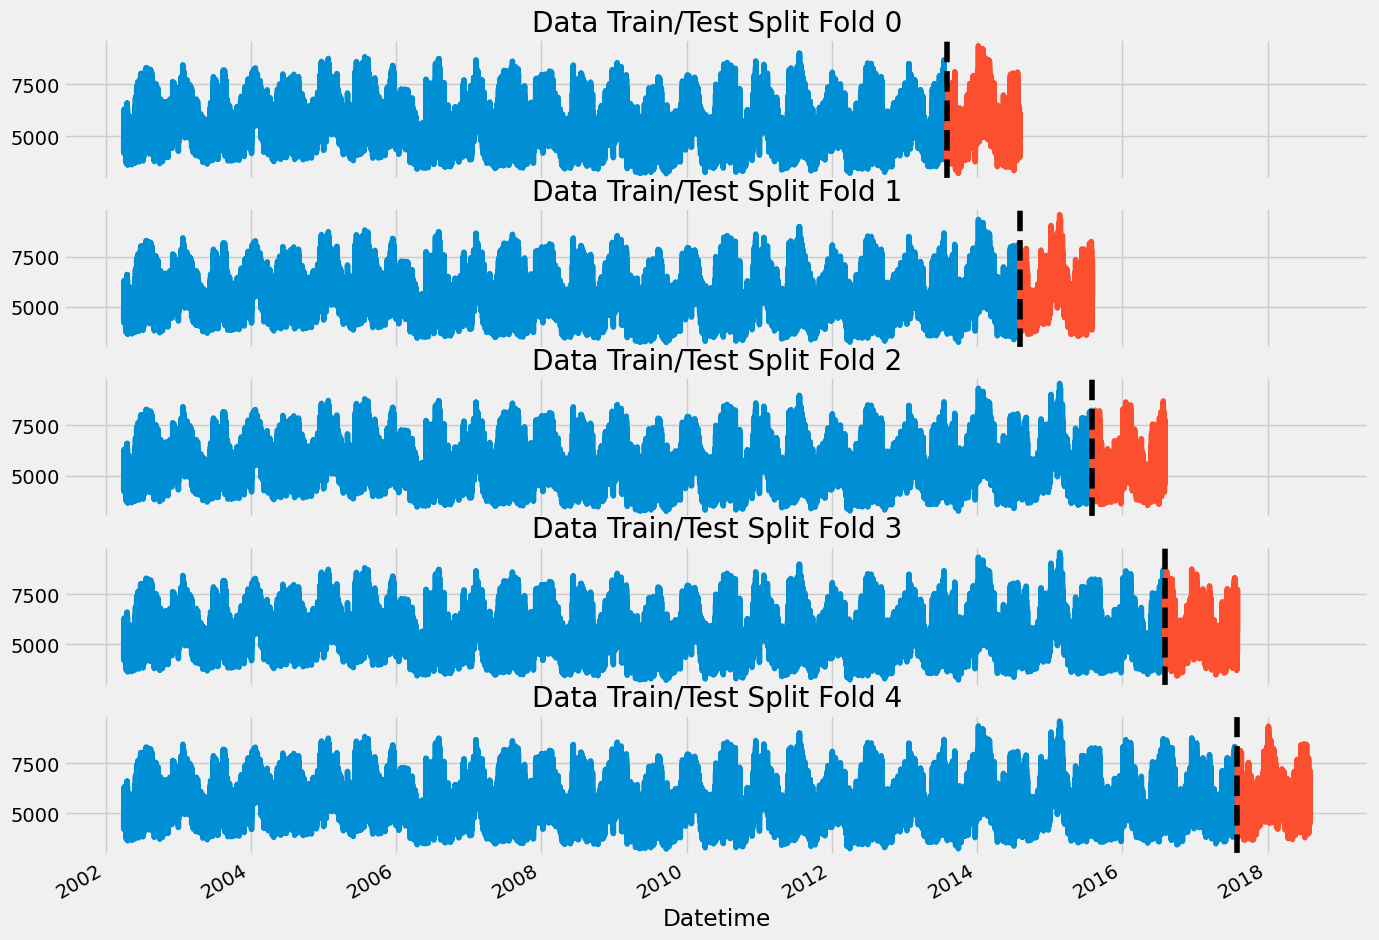

In [13]:
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJMW_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJMW_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [14]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [15]:
df = create_features(df)
df.head()

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-04-01 01:00:00,4374.0,1,0,2,4,2002,91,1,14
2002-04-01 02:00:00,4306.0,2,0,2,4,2002,91,1,14
2002-04-01 03:00:00,4322.0,3,0,2,4,2002,91,1,14
2002-04-01 04:00:00,4359.0,4,0,2,4,2002,91,1,14
2002-04-01 05:00:00,4436.0,5,0,2,4,2002,91,1,14


In [16]:
def add_lags(df):
    target_map = df['PJMW_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [17]:
df = add_lags(df)

In [18]:
df.tail()

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,6545.0,20,3,3,8,2018,214,2,31,7175.0,6987.0,5584.0
2018-08-02 21:00:00,6496.0,21,3,3,8,2018,214,2,31,6957.0,6802.0,5637.0
2018-08-02 22:00:00,6325.0,22,3,3,8,2018,214,2,31,6770.0,6660.0,5513.0
2018-08-02 23:00:00,5892.0,23,3,3,8,2018,214,2,31,6207.0,6162.0,5164.0
2018-08-03 00:00:00,5489.0,0,4,3,8,2018,215,3,31,5713.0,5620.0,4772.0


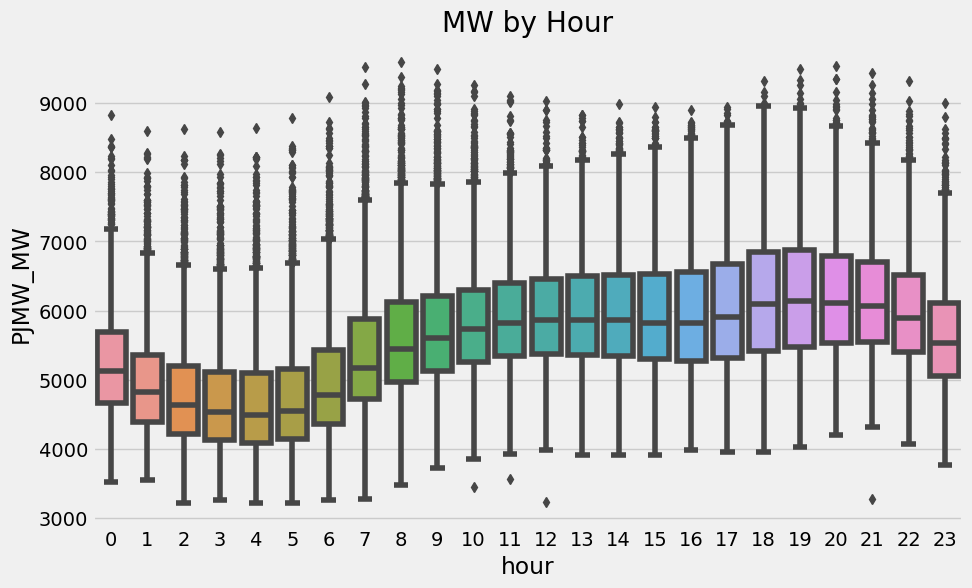

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='hour', y='PJMW_MW')
ax.set_title('MW by Hour')
plt.show()

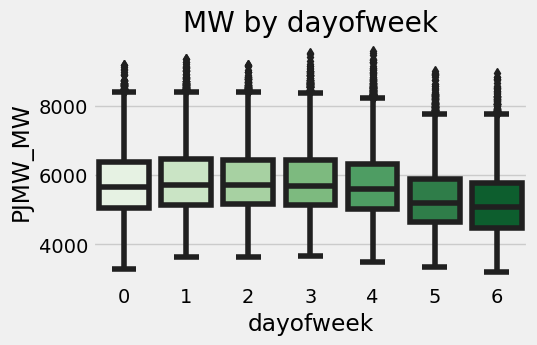

In [20]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=df, x='dayofweek', y='PJMW_MW', palette='Greens')
ax.set_title('MW by dayofweek')
plt.show()

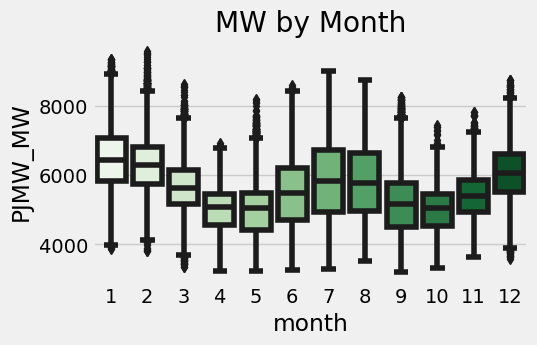

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=df, x='month', y='PJMW_MW', palette='Greens')
ax.set_title('MW by Month')
plt.show()

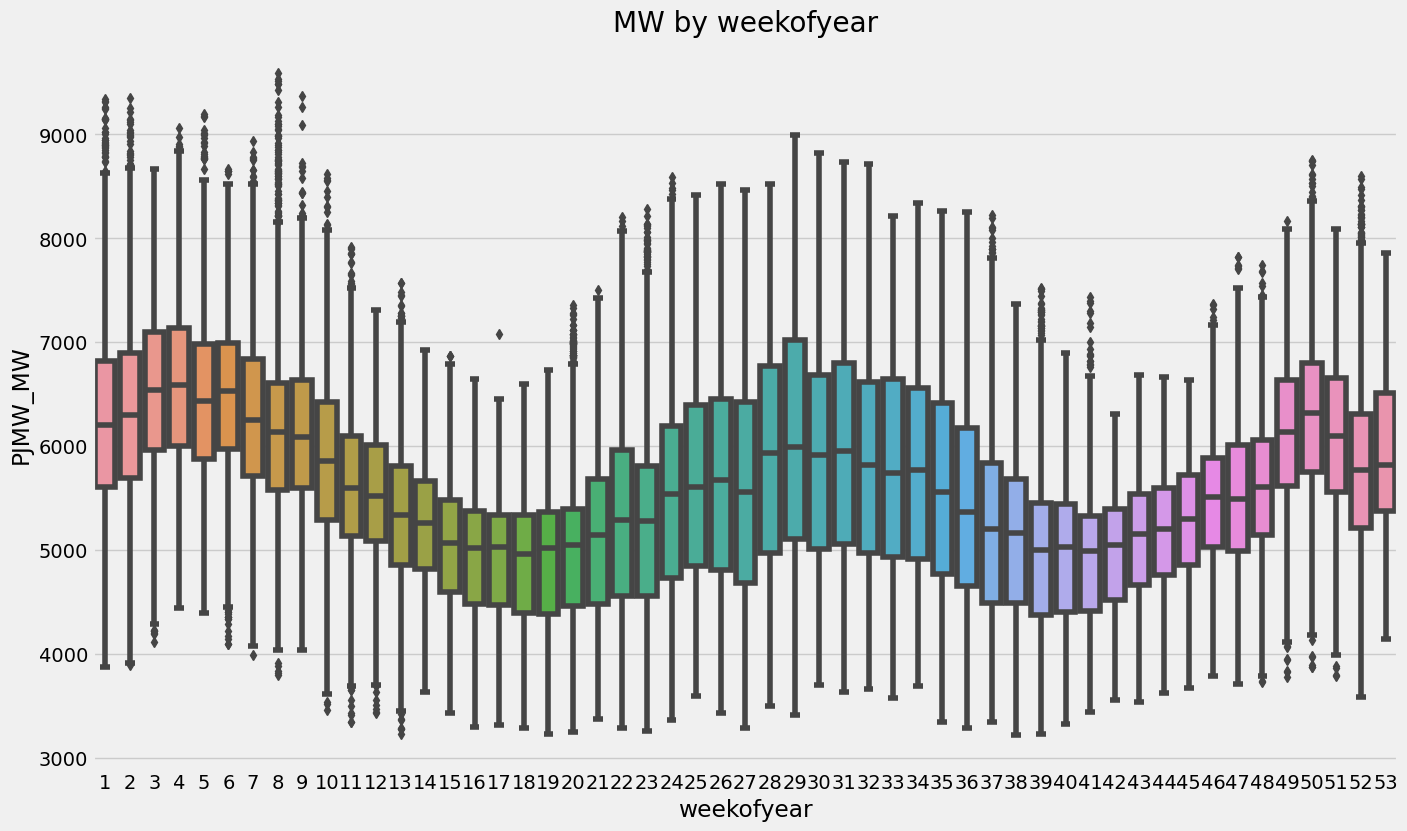

In [22]:
fig, ax = plt.subplots(figsize=(15,9))
sns.boxplot(data=df, x='weekofyear', y='PJMW_MW')
ax.set_title('MW by weekofyear')
plt.show()

In [23]:
fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year','lag1','lag2','lag3']
    TARGET = 'PJMW_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(n_estimators=1000,
                           early_stopping_rounds=50,
                           max_depth=3,
                           learning_rate=0.01)
#Early stopping is a technique used to stop training when the loss on validation dataset starts increase (in the case of minimizing the loss)

    reg.fit(X_train, 
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:5626.11493	validation_1-rmse:5689.34735
[100]	validation_0-rmse:2135.36315	validation_1-rmse:2285.53093
[200]	validation_0-rmse:940.44405	validation_1-rmse:1119.53194
[300]	validation_0-rmse:605.28916	validation_1-rmse:768.36629
[400]	validation_0-rmse:529.26997	validation_1-rmse:671.66873
[500]	validation_0-rmse:506.66614	validation_1-rmse:646.60573
[600]	validation_0-rmse:494.58901	validation_1-rmse:634.09750
[700]	validation_0-rmse:486.28873	validation_1-rmse:629.23244
[800]	validation_0-rmse:479.96583	validation_1-rmse:628.35570
[832]	validation_0-rmse:478.19593	validation_1-rmse:628.45027
[0]	validation_0-rmse:5631.10635	validation_1-rmse:5764.74134
[100]	validation_0-rmse:2138.54033	validation_1-rmse:2344.97439
[200]	validation_0-rmse:945.57191	validation_1-rmse:1158.88660
[300]	validation_0-rmse:613.21322	validation_1-rmse:758.87282
[400]	validation_0-rmse:539.13055	validation_1-rmse:642.75775
[500]	validation_0-rmse:516.77922	validation_1-rmse:610.85689
[6

In [24]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 637.7438
Fold scores:[627.9894558815416, 583.2953408929461, 620.7564233601852, 688.070140652791, 668.6077236756903]


In [25]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','lag1','lag2','lag3']
TARGET = 'PJMW_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[21:03:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5631.04303
[100]	validation_0-rmse:2143.37286
[200]	validation_0-rmse:959.89016
[300]	validation_0-rmse:637.70105
[400]	validation_0-rmse:565.83191
[499]	validation_0-rmse:546.52375


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [26]:
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [27]:
future_w_features = df_and_future.query('isFuture').copy()

In [28]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

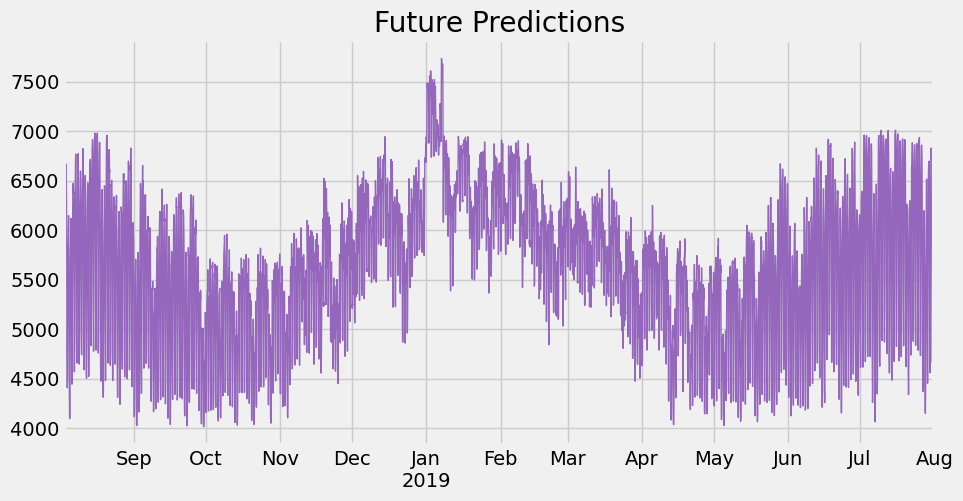

In [29]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

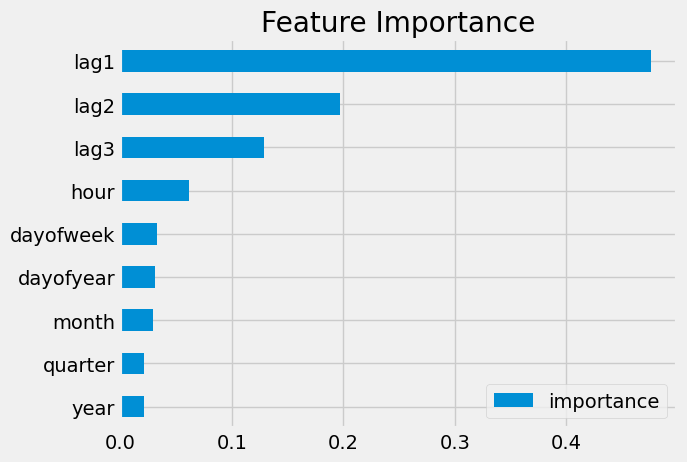

In [30]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [31]:
future_w_features

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,5713.0,5620.0,4772.0,True,5288.620117
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,5260.0,5226.0,4421.0,True,4980.585449
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,4965.0,4913.0,4184.0,True,4777.041504
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,4815.0,4677.0,4085.0,True,4654.298828
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,4620.0,4638.0,4031.0,True,4586.834473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,6816.0,7240.0,6951.0,True,6829.693848
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,6571.0,6970.0,6864.0,True,6783.810547
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,6362.0,6697.0,6670.0,True,6618.363281
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,5881.0,6250.0,6162.0,True,6239.522461


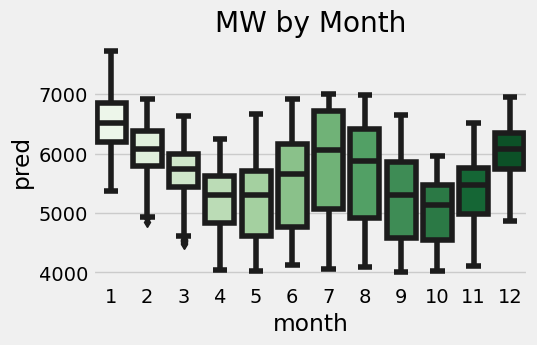

In [32]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=future_w_features, x='month', y='pred', palette='Greens')
ax.set_title('MW by Month')
plt.show()

In [33]:
df.head()

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
Datetime,,,,,,,,,,,,,
2002-04-01 01:00:00,4374.0,1,0,2,4,2002,91,1,14,NaN,NaN,NaN,False
2002-04-01 02:00:00,4306.0,2,0,2,4,2002,91,1,14,NaN,NaN,NaN,False
2002-04-01 03:00:00,4322.0,3,0,2,4,2002,91,1,14,NaN,NaN,NaN,False
2002-04-01 04:00:00,4359.0,4,0,2,4,2002,91,1,14,NaN,NaN,NaN,False
2002-04-01 05:00:00,4436.0,5,0,2,4,2002,91,1,14,NaN,NaN,NaN,False
